**PULSECHAIN SENTIMENT ANALYSIS**

**Data Collection and Initial Processing**

The implementation below performs the Data collection and initial processing for the sentiment analysis on Reddit comments related to Pulsechain. It starts by loading and cleaning the data, then creates word embeddings using Word2Vec. The comments are vectorized using TF-IDF, and K-Means clustering is applied to group the comments into positive, negative, and neutral clusters. Finally, the clusters are visualized using Truncated SVD.

**Step 1: Import libraries**

1. pandas: Used for loading and handling structured data (Reddit comments) in a DataFrame.
2. re (Regular Expressions): Helps with text cleaning, such as removing special characters, links, and unnecessary symbols.
3. nltk (Natural Language Toolkit): A library for text processing tasks.

  * stopwords: Contains a list of common words (e.g., "the", "is") to remove from the text.
  * word_tokenize: Splits comments into individual words (tokens) for further processing.
4. sklearn.feature_extraction.text.TfidfVectorizer: Converts text into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF), which helps identify important words in the dataset.
5. sklearn.cluster.KMeans: Implements K-Means clustering, which groups comments into positive, negative, and neutral categories based on similarity.
6. sklearn.decomposition.PCA: Principal Component Analysis (PCA) is used for dimensionality reduction to help visualize the clusters.
7. gensim.models.Word2Vec: Creates word embeddings, which capture the meaning of words based on their context in the text.
8. matplotlib.pyplot & seaborn: Used for visualizing clusters and sentiment analysis results.
9. h5py: Helps with storing and loading large data efficiently, especially for trained models.
10. numpy: Provides support for numerical computations, such as matrix operations.


11. Downloading Natural Language Toolkit (NLTK) resources:
* nltk.download('punkt'): Downloads the tokenizer required for splitting text into words.
* nltk.download('stopwords'): Downloads a predefined list of common words to remove from the text.

In [1]:
#!pip install nltk

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import numpy as np

# Download required NLTK resources
nltk.download('punkt') # Download the punkt tokenizer
nltk.download('stopwords') # Download the stopwords list
nltk.download('punkt_tab') # Download the missing resource 'punkt_tab'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Step 2: Load CSV File into Google Colab**

Load the data from the uploaded CSV file into a Pandas DataFrame.

In [3]:
from google.colab import files

# Remove any existing files named reddit_data.csv or its variants
!rm -f reddit_data*.csv

uploaded = files.upload() # Upload CSV file manually


Saving reddit_data.csv to reddit_data.csv


Load Data
Load the data from the uploaded CSV file into a Pandas DataFrame.

In [4]:
import io

data_path = list(uploaded.keys())[0]  # Get the name of the uploaded file dynamically (in case the filename varies)

df = pd.read_csv(io.BytesIO(uploaded[data_path])) # Read the CSV file and load it into a Pandas DataFrame.

# Display the first few rows of the dataframe to verify loading
df.head()


,Title,Comment
0,Pulsechain is dead!!,"Prove yourself right.\n\n48,000+ validators\n\..."
1,Pulsechain is dead!!,"Idk what you're talking about, eco is thriving"
2,Pulsechain is dead!!,Didnt people say the same for HEX ? Its not a ...
3,Pulsechain is dead!!,Low quality post. It is in the top 20 chains i...
4,Pulsechain is dead!!,"No. Please, sell. You're not worth our time."


**Step 3: Data Cleaning and Preprocessing**

This step prepares the text dats for sentiment analysis by:

 1. Removing unwanted elements (URLs, emails, special characters, etc.).
 2. Converting text to lowercase.
 3. Removing stopwords to keep only meaningful words.
 4. Eliminating duplicate comments.

In [5]:
# Function to clean text by removing URLs, emails, special characters, and converting to lowercase
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # removes URLs from the text
    text = re.sub(r'\S+@\S+', '', text)  # removes email addresses
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # removes special characters and numbers, keeping only letters and spaces
    text = text.lower()  # converts text to lowercase for consistency
    text = text.strip()  # removes or trims ay unnecessary spaces at the beginning or end of the comment
    return text

# Function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  # Loads a list of common stopwords
    word_tokens = word_tokenize(text)  # Tokenize text into words - this splits text into individual words
    filtered_text = [word for word in word_tokens if word not in stop_words]  # Removes stopwords from the list of words
    return ' '.join(filtered_text)  # Join the remaining words back into a cleaned sentence

# Apply text cleaning and stopword removal to the 'Comment' column
df['cleaned_comment'] = df['Comment'].astype(str).apply(clean_text).apply(remove_stopwords)

# Drop duplicate comments
df = df.drop_duplicates(subset='cleaned_comment')

# Display the first few rows of the cleaned DataFrame
df.head()


,Title,Comment,cleaned_comment
0,Pulsechain is dead!!,"Prove yourself right.\n\n48,000+ validators\n\...",prove right validators active unique wallets h...
1,Pulsechain is dead!!,"Idk what you're talking about, eco is thriving",idk youre talking eco thriving
2,Pulsechain is dead!!,Didnt people say the same for HEX ? Its not a ...,didnt people say hex bull market right hold ra...
3,Pulsechain is dead!!,Low quality post. It is in the top 20 chains i...,low quality post top chains tvl h vol atm
4,Pulsechain is dead!!,"No. Please, sell. You're not worth our time.",please sell youre worth time


In [6]:
# Print columns of the DataFrame to check for 'cleaned_comment'
print(df.columns)

Index(['Title', 'Comment', 'cleaned_comment'], dtype='object')


**Step 4: Create Word Embeddings and Store in HDF5**

In this step, we generate **word embeddings** using Word2Vec and store them in an **HDF5 file** for efficient storage and retrieval.Creating word embeddings using Word2Vec and storing them in an HDF5 file enables handling large datasets efficiently.


**Why Use Word Embeddings?**

Word embeddings transform text data into numerical representations that capture the semantic meaning of words. This is important for **sentiment analysis** because:

* Similar words (e.g., happy and joyful) have similar vector representations, making it easier to detect sentiment.
* Words that appear in similar contexts get similar embeddings, helping the model understand relationships between words.
* It reduces the **dimensionality** of text data while preserving meaning, making it computationally efficient for clustering.

In [7]:
# Create Word Embeddings using Word2Vec
sentences = df['cleaned_comment'].apply(word_tokenize).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an HDF5 file to store Word2Vec embeddings
with h5py.File('word_embeddings.h5', 'w') as f:
    embeddings_dataset = f.create_dataset('embeddings', shape=(len(df), 100), dtype='float32')

    # Generate Word2Vec embeddings and store in HDF5
    for i, text in enumerate(df['cleaned_comment']):
        tokens = word_tokenize(text)
        token_vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]

        if token_vectors:  # Check if there are valid token vectors
            embedding = np.mean(token_vectors, axis=0)
        else:
            embedding = np.zeros(word2vec_model.vector_size)  # Handle case with no valid tokens

        embeddings_dataset[i] = embedding


**Breaking Down the Implementation**
1. Tokenizing Comments for Word2Vec Training
```
sentences = df['cleaned_comment'].apply(word_tokenize).tolist()
```
 * ```word_tokenize```: Splits each comment into individual words (tokens).
 * ```.tolist()```: Converts the processed comments into a list of tokenized sentences.

2. Training the Word2Vec Model
```
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
```

  * ```Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)```
    * ```vector_size=100```: Each word is represented as a 100-dimensional vector.
    * ```window=5```: Looks at 5 words before and after a word to learn context.
    * ```min_count=1```: Includes all words appearing at least once in the corpus.
    * ```workers=4```: Uses 4 CPU threads to speed up training.

3. Storing Embeddings in an HDF5 File
```
with h5py.File('word_embeddings.h5', 'w') as f:
    embeddings_dataset = f.create_dataset('embeddings', shape=(len(df), 100), dtype='float32')
    ```
  * *Why Use HDF5?*

    * **Efficient storage**: Stores large arrays without consuming too much memory.
    * **Fast access**: Allows quick retrieval of embeddings without reprocessing data.
    * **Scalability**: Works well for large datasets, unlike CSV files.


4. Generating and Storing Word Embeddings
```
for i, text in enumerate(df['cleaned_comment']):
    tokens = word_tokenize(text)
    token_vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]

    if token_vectors:  # Check if there are valid token vectors
        embedding = np.mean(token_vectors, axis=0)  # Average word vectors to create a comment-level embedding
    else:
        embedding = np.zeros(word2vec_model.vector_size)  # Handle case with no valid tokens

    embeddings_dataset[i] = embedding  # Store in HDF5 file
```

*How it Works*:
 1. **Tokenizes each comment** into words.
 2. **Extracts word vectors** for tokens found in the Word2Vec model.
 3. **Averages the vectors** to get a **comment-level embedding** (one vector per comment).
 4. **Handles missing tokens** by assigning a zero vector.
 5. **Stores embeddings** in the HDF5 dataset for future use.

*Why Store Comment Embeddings Instead of Raw Text?*
* **Makes clustering easier**: Instead of clustering raw text, we now cluster numerical representations of comments.
* **Speeds up processing**: We don't have to re-train Word2Vec every time.
* **Allows reuse**: The embeddings can be loaded into other models without reprocessing text.

**Step 5: Load Embeddings from HDF5 and Perform TF-IDF Vectorization** (Optional)
Use HDF5 datasets or Numpy memmap for managing large arrays efficiently.

In this step, we **load the precomputed word embeddings** from the HDF5 file and **apply TF-IDF vectorization** to transform the cleaned comments into numerical features. This ensures that our clustering algorithm can work effectively with both pre-trained embeddings and statistical text representations.

Why Load Embeddings from HDF5?
1. **Efficient Memory Usage**: HDF5 allows us to load embeddings **on-demand** without keeping everything in memory.
2. **Fast Access**: We avoid re-training Word2Vec every time by simply loading the saved embeddings.
3. **Scalability**: Works well for **large datasets** where storing in a CSV or Pandas DataFrame would be inefficient.

Why Use TF-IDF?

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a statistical measure that reflects how important a word is in a document relative to the entire dataset. This helps emphasize words that are meaningful for sentiment analysis.

How TF-IDF Works:
1. **Counts how often a word appears in a comment** (Term Frequency - TF).
2. **Reduces the weight of common words** across multiple comments (Inverse Document Frequency - IDF).
3. **Creates a sparse matrix** where each comment is represented as a vector of weighted word frequencies.

In [8]:
# Load embeddings from HDF5 file
with h5py.File('word_embeddings.h5', 'r') as f:
    embeddings = f['embeddings'][:]

# Perform TF-IDF Vectorization on the cleaned comments
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_comment'])


**Why Combine Word Embeddings with TF-IDF?**
1. **Embeddings capture semantic meaning**: Word2Vec creates context-aware word vectors.
2. **TF-IDF emphasizes important words**: Helps the clustering algorithm focus on key terms.
3. **Improves clustering performance**: The combination of dense embeddings and sparse TF-IDF features provides a **better representation of sentiment** in the comments.

**Step 6: K-Means Clustering**

Why Use K-Means?
1. **Unsupervised Learning**: K-Means automatically **groups similar comments** without labeled data.
2.**Identifies Sentiment Patterns**: Helps separate **positive, negative, and neutral** comments based on their text representation.
3.**Scalability**: Can handle **large datasets efficiently** compared to hierarchical clustering.

In [9]:
from sklearn.cluster import KMeans

# K-Means Clustering
# Define the number of clusters (e.g., 3 for positive, negative, neutral)
num_clusters = 3  # Change this to 2 if you want binary sentiment classification

# Initialize K-Means clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)  # Explicitly set n_init

# Fit the model and assign cluster labels to each comment
df['Cluster'] = kmeans.fit_predict(X)

**Understanding the Parameters**
```
num_clusters = 3

```

* ```num_clusters=3```: Groups comments into **three sentiment clusters**.
 * Cluster 0: Likely negative comments.
 * Cluster 1: Likely neutral comments.
 * Cluster 2: Likely positive comments.
* Change this to **2 for binary classification** (positive vs. negative).

```
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
```

* ```random_state=42```: Ensures reproducible results.
* ```n_init=10```: Runs the clustering algorithm 10 times with different initial values and picks the best one.

```
df['Cluster'] = kmeans.fit_predict(X)

```

* ```fit_predict(X)```:
 * **Fits** the K-Means model on the TF-IDF-transformed comments.
 * **Predicts** which cluster each comment belongs to.
 * Stores the cluster label in a new column ```Cluster```.

**Step 7: Add Class Labels**

In this step, we **assign sentiment labels** (positive, negative, or neutral) to the clusters created by K-Means. This helps interpret the clustering results meaningfully.




In [10]:
# Adding class labels
df['Label'] = df['Cluster'].map({0: 'positive', 1: 'negative', 2: 'neutral'})  # Modify according to your clusters

***Mapping Cluster numbers to Sentiment Labels***

**How this works:**
* ```df['Cluster']``` contains numerical cluster assignments (0, 1, or 2).
* ```.map({0: 'positive', 1: 'negative', 2: 'neutral'})``` replaces cluster numbers with sentiment labels.
* Creates a new ```Label``` column with human-readable sentiment categories.

***Ajusting Cluster-to-Sentiment Mapping (If Needed)***

K-Means assigns clusters arbitrarily, so **cluster numbers might not align with expected sentiment**. You may need to check some sample comments from each cluster and adjust the mapping accordingly.
```
# Verify cluster assignments
df.groupby('Label').head(10)  # Check sample comments from each cluster
```
* If **negative comments are labeled as ‘positive’**, you can swap labels in the mapping ```{0: 'negative', 1: 'positive', 2: 'neutral'}```


***Why Add Labels?***

✅ Improves Interpretability → Cluster numbers are meaningless without sentiment labels.

✅ Prepares Data for Further Analysis → Allows visualization, statistics, and model validation.

✅ Facilitates Sentiment Analysis → Can now analyze how many comments are positive, negative, or neutral.

**Step 8: Visualize Clusters Using Trucated SVD**

In this step, we use **Truncated SVD (Singular Value Decomposition)** to reduce the high-dimensional TF-IDF feature space into two dimensions for visualization. This helps us **understand how the clusters are distributed** in a lower-dimensional space.

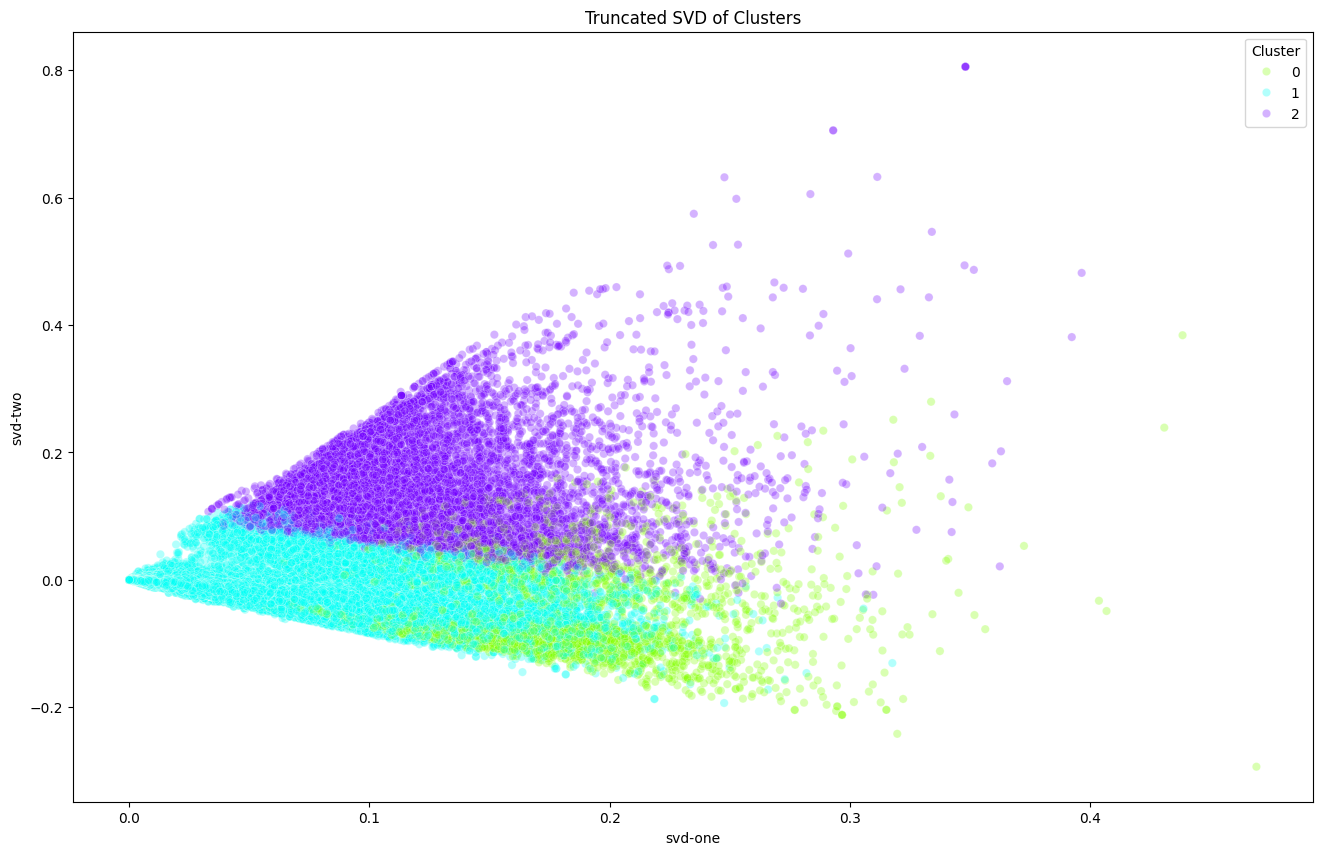

In [11]:
from sklearn.decomposition import TruncatedSVD

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=2, random_state=42)

# Perform Truncated SVD
svd_result = svd.fit_transform(X)

# Add SVD results to the dataframe
df['svd-one'] = svd_result[:, 0]
df['svd-two'] = svd_result[:, 1]

# Plot SVD results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="svd-one", y="svd-two",
    hue="Cluster",
    palette=sns.color_palette("hsv", num_clusters),
    data=df,
    legend="full",
    alpha=0.3
)
plt.title('Truncated SVD of Clusters')
plt.show()

**Explanantion**

*Step1 - Applying Truncated SVD for Dimensionality Reduction*
```
from sklearn.decomposition import TruncatedSVD

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=2, random_state=42)

# Perform Truncated SVD
svd_result = svd.fit_transform(X)
```
Why Use Truncated SVD?

* **Reduces Dimensionality** → Converts thousands of TF-IDF features into **just** two principal components.
* **Preserves Important Variance** → Unlike PCA, **Truncated SVD works with sparse matrices**, making it ideal for TF-IDF vectors.
* **Enables Visualization** → Allows plotting the clusters in a **2D space** for better interpretation.

*Step2 - Adding SVD Components to the DataFrame*
```
# Add SVD results to the dataframe
df['svd-one'] = svd_result[:, 0]
df['svd-two'] = svd_result[:, 1]
```

* ```svd_result[:, 0]``` → First principal component (captures most variance).
* ```svd_result[:, 1]``` → Second principal component.
These two components are added to **new columns** in the DataFrame for visualization.

*Step3. Visualizing the Clusters*
```import matplotlib.pyplot as plt
import seaborn as sns

# Plot SVD results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="svd-one", y="svd-two",
    hue="Cluster",
    palette=sns.color_palette("hsv", num_clusters),
    data=df,
    legend="full",
    alpha=0.3
)
plt.title('Truncated SVD of Clusters')
plt.show()
```
How the Visualization Works:

✅ **Scatterplot Representation** → Plots each comment as a **point** in 2D space.

✅ **Color-coded Clusters** → Different clusters (positive, negative, neutral) are **assigned unique** colors.

✅ **Transparency** (```alpha=0.3```) → Helps in identifying overlapping points.



***Interpreting the Plot***

* **Well-separated clusters** → The clustering algorithm successfully grouped similar sentiments together.
* **Overlapping clusters** → Some comments may have ambiguous sentiment and need manual review or fine-tuning.
* **Densely packed areas** → High similarity among comments in that cluster.


**Step 9: Save the Results to CSV**

In this step, we **save the labeled and clustered Reddit comments** to a CSV file. These results will be used as input for our upcoming **classic machine learning model**, where we will build a **neural network** to train on this data.

Since training a model isn’t just about getting results, we will also go through **validation** and **fine-tuning** to find the best set of parameters. The saved dataset will serve as the foundation for our experiments, ensuring we can iteratively improve model performance.


In [12]:
# Save the results to CSV
df.to_csv('labeled_reddit_comments.csv', index=False)

**How Saving the DataFrame as a CSV works:**
 * df.to_csv('labeled_reddit_comments.csv', index=False)
    * Saves the DataFrame as a CSV file named labeled_reddit_comments.csv.
    * index=False → Excludes the DataFrame’s index column from the CSV.

**What Data is Included in the CSV?**

The saved file will contain:

✅ Original Reddit Comments (Comment)

✅ Cleaned Comments (cleaned_comment)


✅ Sentiment Labels (Label: positive, negative, neutral)

✅ Dimensionality Reduction Features (svd-one, svd-two)


**Why Save the Results?**

  * **Prepares Data for Neural Network Training** → The dataset will be used to **train a classic ML model**.
  * **Supports Hyperparameter Tuning** → We will fine-tune the model based on **validation results**.
  * **Facilitates Iterative Improvement** → Saving results allows us to **retrain with different configurations** to find the best parameters.

Download csv with results:

We need to download the file to our local machine before training.

In [13]:
from google.colab import files

# Download the file
files.download('labeled_reddit_comments.csv') # this triggers a download of the saved dataset to your local machine.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Why Download the File?

✅ Use the Data Locally → If we plan to train the neural network outside Colab (e.g., on a local machine or cloud platform).

✅ Backup for Future Use → Keep a copy of the dataset for additional training runs or comparisons.

✅ Ensures Dataset Consistency → Helps maintain a stable dataset while tuning and validating different ML models.

**Next Step: Preparing for Model Training**

With the dataset downloaded, we can now move on to training our neural network using the labeled Reddit comments. This will involve:

🔹 Building a neural network model

🔹 Training on the saved dataset

🔹 Validating and fine-tuning parameters to achieve the best results
